## Import

In [1]:
from bt import Backtest, Strategy
import pandas as pd
import yfinance as yf

/Users/justinleng/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/justinleng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Query

In [2]:
# data = {
#     'Date': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05'],
#     'Open': [150.0, 151.2, 153.5, 152.8, 152.0],
#     'High': [152.3, 153.8, 155.0, 154.2, 153.5],
#     'Low': [149.5, 150.7, 152.0, 151.5, 151.2],
#     'Close': [151.5, 153.0, 154.5, 153.2, 152.8],
#     'Volume': [100000, 120000, 95000, 110000, 105000]
# }
msft = yf.Ticker("MSFT")
msft_history = msft.history(period="240mo")
data = msft_history

# 1a) Create a DataFrame
df = pd.DataFrame(data)

# 1b) Convert the 'Date' column to datetime format
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")

## Strategy Creation

In [3]:
from lib import crossover
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class SmaCross(Strategy):    
    n1 = 10
    n2 = 20

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

## Backtest

#### Run

In [4]:
# strategy_params = {
#     "n1": 10,
#     "n2": 10,
# }         

bt = Backtest(df, strategy=SmaCross, cash=100_000)
res = bt.run()
res

Start                     2004-01-29 00:00...
End                       2024-01-29 00:00...
Duration                   7305 days 00:00:00
Exposure Time [%]                   99.066349
Equity Final [$]                 180123.86379
Equity Peak [$]                 292118.434983
Return [%]                          80.123864
Buy & Hold Return [%]             2227.422964
Return (Ann.) [%]                      2.9897
Volatility (Ann.) [%]               27.620739
Sharpe Ratio                         0.108241
Sortino Ratio                        0.163001
Calmar Ratio                          0.05857
Max. Drawdown [%]                   -51.04449
Avg. Drawdown [%]                   -5.251859
Max. Drawdown Duration     3136 days 00:00:00
Avg. Drawdown Duration      135 days 00:00:00
# Trades                                  253
Win Rate [%]                         42.29249
Best Trade [%]                      30.258587
Worst Trade [%]                    -12.718668
Avg. Trade [%]                    

#### Optimize

In [5]:
strategy_params_limit = {
    "n1": [5, 200],
    "n2": [5, 200],
}

result = bt.optimize(strategy_params_limit=strategy_params_limit)
# result, result._strategy

Start                     2004-01-29 00:00...
End                       2024-01-29 00:00...
Duration                   7305 days 00:00:00
Exposure Time [%]                     98.8677
Equity Final [$]                291940.076576
Equity Peak [$]                 442281.177177
Return [%]                         191.940077
Buy & Hold Return [%]             2227.422964
Return (Ann.) [%]                    5.509706
Volatility (Ann.) [%]               27.113411
Sharpe Ratio                          0.20321
Sortino Ratio                        0.314816
Calmar Ratio                         0.126317
Max. Drawdown [%]                  -43.618222
Avg. Drawdown [%]                    -6.25203
Max. Drawdown Duration     1971 days 00:00:00
Avg. Drawdown Duration       94 days 00:00:00
# Trades                                  141
Win Rate [%]                        44.680851
Best Trade [%]                      29.290746
Worst Trade [%]                    -13.139493
Avg. Trade [%]                    

## Event Bias Analysis

## Walk Forward Optimisation

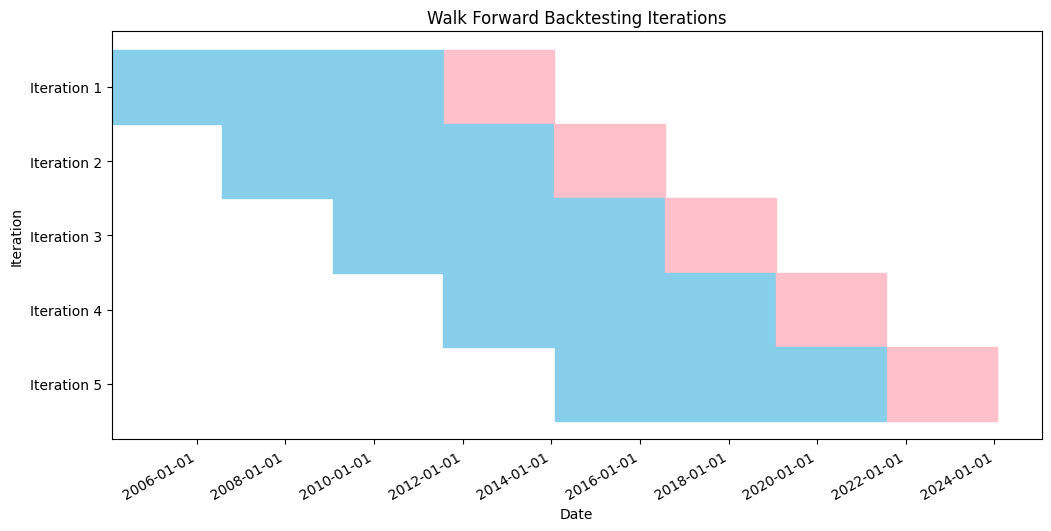

Start                     2004-01-29 00:00...
End                       2011-07-26 00:00...
Duration                   2734 days 23:00:00
Exposure Time [%]                   95.124536
Equity Final [$]                  6261.171529
Equity Peak [$]                   19767.10409
Return [%]                         -37.388285
Buy & Hold Return [%]               26.107089
Return (Ann.) [%]                   -6.061351
Volatility (Ann.) [%]               33.246733
Sharpe Ratio                        -0.182314
Sortino Ratio                       -0.259647
Calmar Ratio                        -0.075472
Max. Drawdown [%]                   -80.31306
Avg. Drawdown [%]                   -6.126793
Max. Drawdown Duration     1138 days 00:00:00
Avg. Drawdown Duration       66 days 00:00:00
# Trades                                   29
Win Rate [%]                        65.517241
Best Trade [%]                      14.274964
Worst Trade [%]                    -56.995969
Avg. Trade [%]                    

In [6]:
bt.runWF(iter=5, strategy_params_limit=strategy_params_limit)

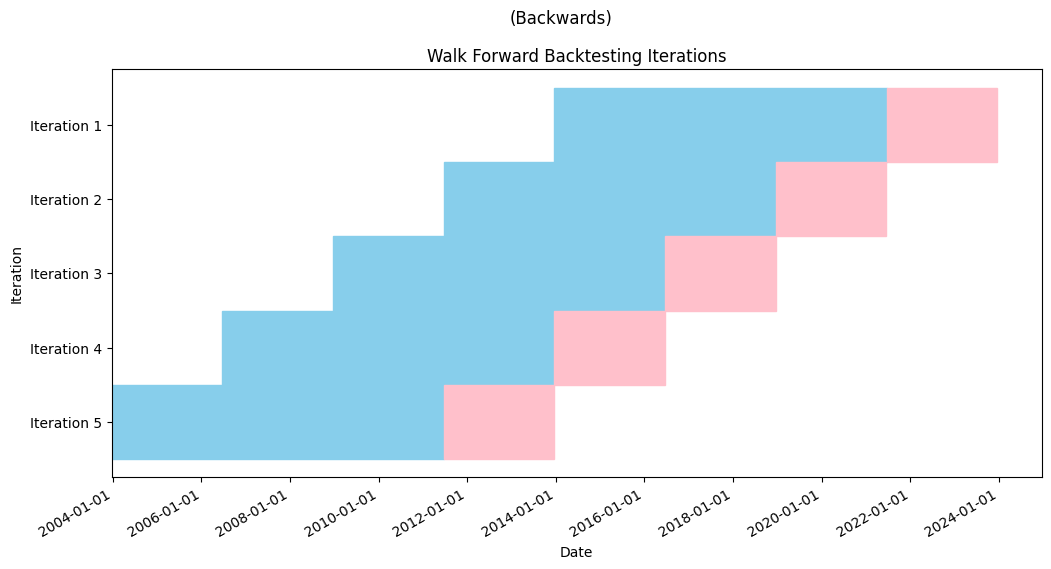

                      Start                       End          Type           Duration  Exposure Time [%]  Equity Final [$]  Equity Peak [$]  Return [%]  Buy & Hold Return [%]  Return (Ann.) [%]  Volatility (Ann.) [%]  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max. Drawdown [%]  Avg. Drawdown [%] Max. Drawdown Duration Avg. Drawdown Duration  # Trades  Win Rate [%]  Best Trade [%]  Worst Trade [%]  Avg. Trade [%] Max. Trade Duration Avg. Trade Duration  Profit Factor  Expectancy [%]       SQN  Kelly Criterion               _strategy  \
0 2013-12-19 00:00:00-05:00 2021-06-18 00:00:00-04:00  Optimization 2737 days 23:00:00          45.945946          0.000000     15934.517864 -100.000000             731.499856           0.000000             278.505006      0.000000       0.000000      0.000000        -100.000000          -9.455905              1795 days               135 days        10     80.000000       17.815409      -101.818656        0.000000            727 days            126 days

In [7]:
# Walk-Backwards
bt.runWF(iter=5, strategy_params_limit=strategy_params_limit, backwards=True)



## Results and Conclusion